**<h2>Computing Generalisation error** 

Importing relevant packages from PyTorch

In [1]:
"""
Created on Sat May 15 17:34:55 2021
@author: Katerina Karoni
"""
import torch                        # Torch is an open-source machine learning library, a scientific computing framework,
                                       #and a script language
import torch.nn as nn
import torch.nn.functional as F     # Convolution Functions
import torch.optim as optim         # Package implementing various optimization algorithms
import matplotlib.pyplot as plt
from torchvision import datasets, transforms  #The torchvision package consists of popular datasets, model 
                                              #architectures, and common image transformations for computer vision
from torch.utils.data import DataLoader, TensorDataset       #Data loading utility class
from torch import Tensor
import pandas as pd

import numpy as np
import random
import os
import ase
from ase import Atoms
from ase.io import read

import time

**<h3>Training and Test Set**

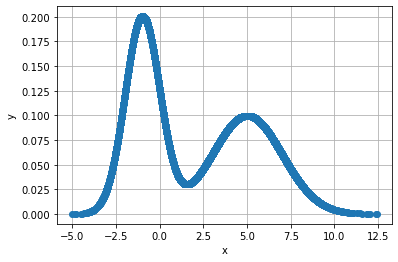

In [2]:
mu, sigma = 0, 1 # mean and standard deviation of normal distribution

# # Double well potential
# Eo = 2*10**(-4) #Hartree
# c  = 0.045

#x  = np.linspace(-4, 4, num=1500) #np.random.uniform(-6,6,1000) #np.random.normal(mu, sigma, 2500) #np.random.exponential(0.63,size=2500)
# x  = np.reshape(x,(len(x),1))

# V  = (1/np.sqrt(2*np.pi*sigma**2))*np.exp(-(x-mu)**2/(2*sigma**2))   #Eo * (c * x**4 - x**2) 
# V  = np.reshape(V,(len(V),1))

N=10000
mu1, sigma1 = 5, 2
mu2, sigma2 = -1, 1
x1 = np.random.normal(mu1, sigma1, N)
x2 = np.random.normal(mu2, sigma2, N)
x = np.concatenate([x1, x2])
x  = np.reshape(x,(len(x),1))


V = 0.5*(1/np.sqrt(2*np.pi*sigma1**2))*np.exp(-(x-mu1)**2/(2*sigma1**2)) + 0.5*(1/np.sqrt(2*np.pi*sigma2**2))*np.exp(-(x-mu2)**2/(2*sigma2**2))
V  = np.reshape(V,(len(V),1))

# shuffler = np.random.permutation(len(V))

# x = x[shuffler]

# V = V[shuffler]

test_set = torch.FloatTensor(x)
test_labels = torch.FloatTensor(V)


plt.plot(x,V,'o')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()

In [3]:
# data_size            = np.shape(V)[0]       
# training_set_size    = data_size - 500

# # # Computing variance and mean on the training data only!
# # x_train = x[:training_set_size]
# # var  = np.std(x_train)
# # mean = np.mean(x_train)

# # normalize all data (training and test), using training set mean and variance
# data_set = x#(x-mean)/var 


# data_set = torch.FloatTensor(data_set)          


# # V_train  = V[:training_set_size]
# # var_lab  = np.std(V_train)
# # mean_lab = np.mean(V_train)

# labels   = V #(V-mean_lab)/var_lab
# labels = torch.FloatTensor(V)        



# # Splitting the adataset into training and test set
# training_set         = data_set[:training_set_size]
# test_set             = data_set[training_set_size:]

# train_labels         = labels[:training_set_size]
# test_labels          = labels[training_set_size:]

# # Dataset
# dataset = TensorDataset(training_set, train_labels)
# #print(dataset[0])

# # Creating the batches
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=training_set_size//8,
#                                            shuffle=True, num_workers=2, drop_last=False)



In [4]:
def generate_data():
    
    N=500
    mu1, sigma1 = 5, 2
    mu2, sigma2 = -1, 1
    x1 = np.random.normal(mu1, sigma1, N)
    x2 = np.random.normal(mu2, sigma2, N)
    x = np.concatenate([x1, x2])
    x  = np.reshape(x,(len(x),1))
    V = 0.5*(1/np.sqrt(2*np.pi*sigma1**2))*np.exp(-(x-mu1)**2/(2*sigma1**2)) + 0.5*(1/np.sqrt(2*np.pi*sigma2**2))*np.exp(-(x-mu2)**2/(2*sigma2**2))
    V  = np.reshape(V,(len(V),1))
    
    data_size            = np.shape(V)[0]       
    data_set = x

    data_set = torch.FloatTensor(data_set)          

    labels   = V 
    labels = torch.FloatTensor(V)        

    training_set         = data_set
    train_labels         = labels

    # Dataset
    dataset = TensorDataset(training_set, train_labels)

    # Creating the batches
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=data_size//10,
                                               shuffle=True, num_workers=2, drop_last=False)
    return data_set, labels,dataloader

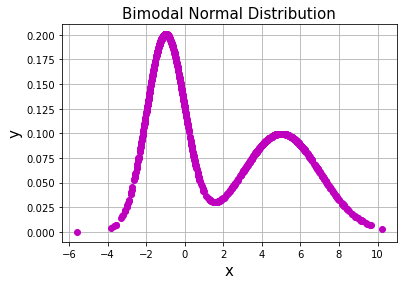

In [5]:
data       = generate_data()
data_set   = data[0]
labels     = data[1]
dataloader = data[2]

plt.plot(data_set,labels,'om')
plt.grid()
plt.xlabel('x',fontsize=15)
plt.ylabel('y',fontsize=15)
plt.title('Bimodal Normal Distribution',fontsize=15)
plt.savefig('Bimodal_Norma_Distribution')

**<h3> Building Neural Network Architecture**

In [93]:
class BPNN(nn.Module):
    def __init__(self):
        super(BPNN, self).__init__()
        self.fc1 = nn.Linear(1, 5)        # where fc stands for fully connected 
        self.fc2 = nn.Linear(5, 5)
        self.fc3 = nn.Linear(5, 5)
        self.fc_out = nn.Linear(5, 1)      # should this be defined here, given that we are not trying to optimise
        
    def forward(self, x,train = True):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
#        x = torch.tanh(self.fc3(x))
        x = torch.sigmoid(self.fc_out(x))
#         x = torch.reshape(x,[1])
        return x


**<h3>Training the Neural Network**

In [94]:
def training(dataloader):
    torch.use_deterministic_algorithms(True)
    seed = 3
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    net = BPNN()
    criterion = torch.nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.005)
    #optimizer = optim.SGD(net.parameters(), lr=0.5, momentum=0.01)
    
    nepochs = 800
    losss = np.zeros(nepochs)
    for epoch in range(nepochs):  # loop over the dataset multiple times

        for i, data in enumerate(dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)        
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()


            losss[epoch] = loss
#            print('[%d, %5d] loss: %.15f' %
#                      (epoch + 1, i + 1, loss))

    print('Finished Training')
    return losss, nepochs, net

**<h3>Plotting loss and prediction vs actual label**

In [95]:
def plot_loss(nepochs, losss,i):
    plt.plot(list(range(nepochs)),losss)
    plt.yscale('log')
    plt.grid()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Average training loss per epoch')
    plt.show()
#    plt.savefig('loss_{0}'.format(i))
#    return

In [96]:
def plot_prediction(test_set,test_labels,net,i):
    prediction = np.zeros(np.shape(test_labels)[0])
    for j in range(np.shape(test_set)[0]):
        prediction[j] = net(test_set[j])#[0]
    prediction = np.reshape(prediction,(len(prediction),1))
    
    plt.plot(test_set,test_labels, 'om',label = '$\pi(x)$')
    plt.plot(test_set,prediction, 'o', color='blue', label = '$\hat{\pi}(x)$')
    plt.grid()
#    plt.ticklabel_format(axis="y", style="plain")
    plt.title('Test set predictions vs actual labels')
    plt.legend()
    plt.show()
#    plt.savefig('pred_vs_lab{0}'.format(i))
    return prediction

**<h3>Computing Kullback Leibler Divergence**

In [97]:
# def kl_divergence(p, q):
#     kl_div = 0
#     for i in range(len(p)):
#         if p[i] != 0:
#             kl_div = kl_div + p[i] * np.log(p[i]/q[i])  # this would have been correct if we were
                                                          # multiplying by dx and used linspace for the points
#         else:
#             print('zero')
#     return kl_div

In [98]:
def kl_divergence(p, q):       # monte carlo (the test set has been sampled from the binomial distribution)
    kl_div = 0
    for i in range(len(p)):
        if p[i] != 0:
            kl_div = kl_div + np.log(p[i]/q[i]) 
        else:
            print('zero')
    return kl_div/len(p)

In [99]:
def mean_sq_error(p, q):
    mse = 0
    for i in range(len(p)):
        mse = mse + (p[i]-q[i])**2
    mse = mse/len(p)
    return mse

**<h3>Computing Normalisation Constant**

In [100]:
def normalisation_const(net):
    Z  = 0
    num_points = 20000
    minimum    = -5
    maximum    = 12.5
    x  = np.linspace(minimum, maximum, num=num_points)
    x  = np.reshape(x,(len(x),1))
    x = torch.FloatTensor(x)
    
    dx = (12.5 + 5)/(num_points-1)
    for i in range(num_points-1):
        Z  = Z + net(x[i])*dx
    return float(Z)

**<h3>Main loop - Computing generalisation error**

Finished Training
105.49825286865234


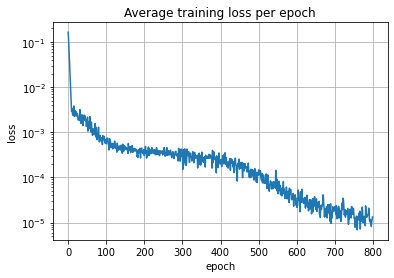

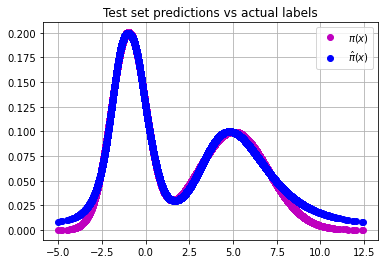

0 0.0372035207511659
0 6.524799159364259e-05
Finished Training
103.96803975105286


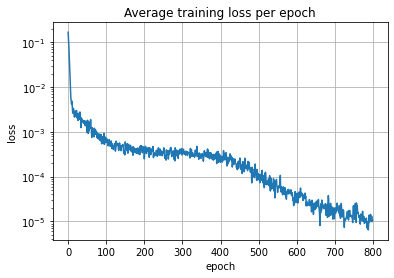

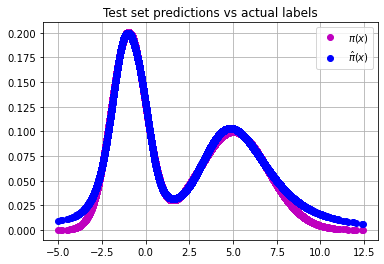

1 0.03431423954636693
1 8.027843047209062e-05
Finished Training
101.44659638404846


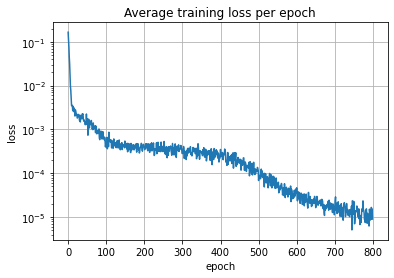

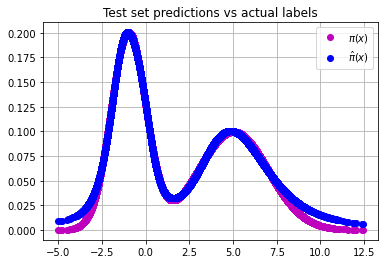

2 0.03269927686708863
2 6.177861241148291e-05
Finished Training
100.40316486358643


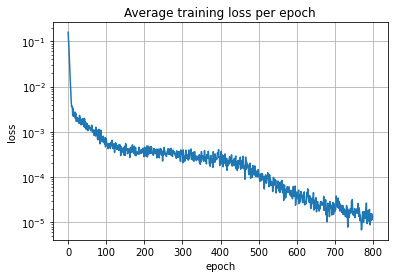

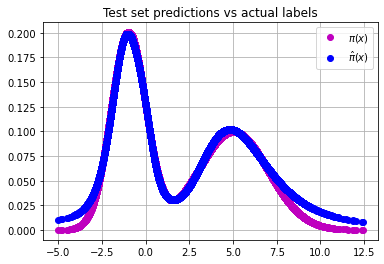

3 0.04284079679056184
3 0.00011284838727303692
Finished Training
99.53008246421814


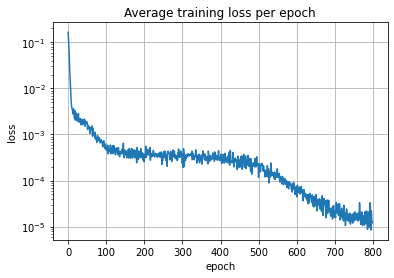

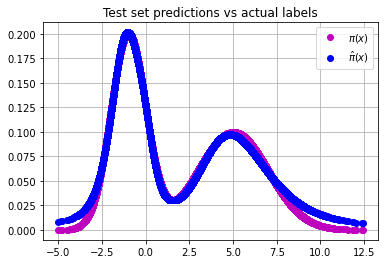

4 0.03504182100898954
4 5.436238104381685e-05
Finished Training
100.04706501960754


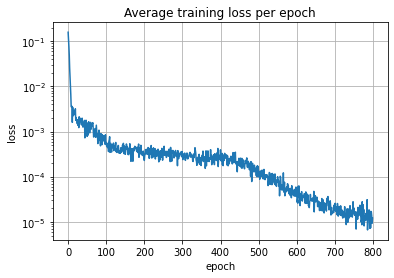

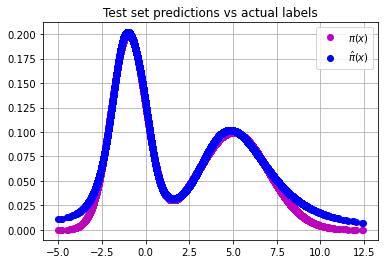

5 0.039974592654355254
5 9.252913297069768e-05
Finished Training
94.68566656112671


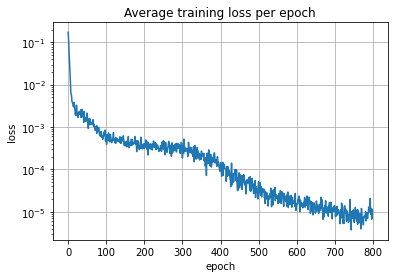

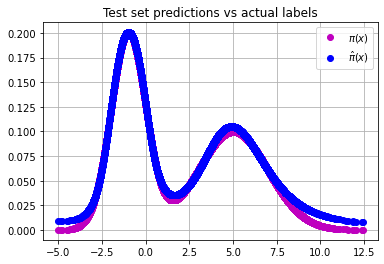

6 0.030173107018913885
6 6.005047282522328e-05
Finished Training
93.59993529319763


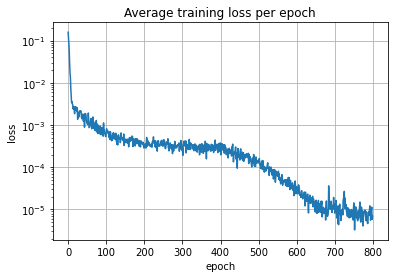

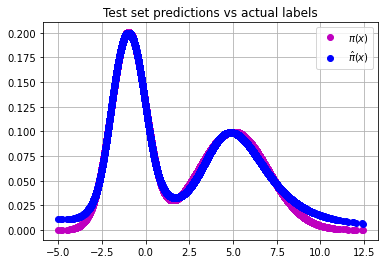

7 0.031115289072841473
7 3.932418581767156e-05
Finished Training
92.89541387557983


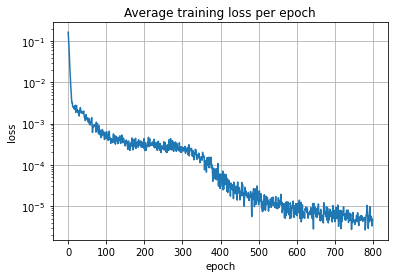

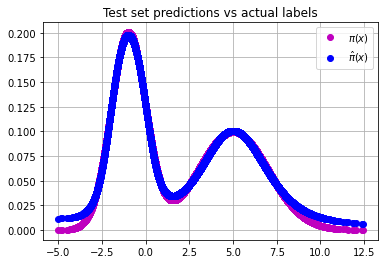

8 0.02877186643697949
8 4.244164150138696e-05
Finished Training
94.83201146125793


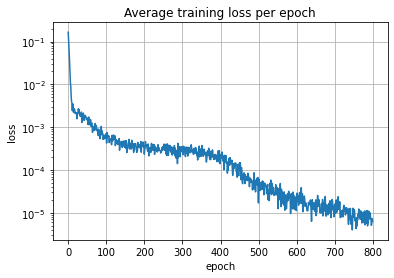

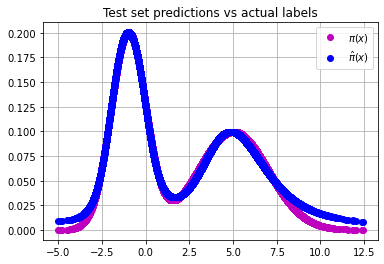

9 0.03542354112913421
9 5.277573464278441e-05
Finished Training
122.08763074874878


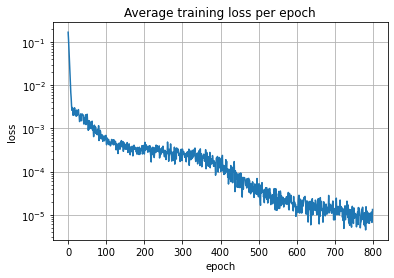

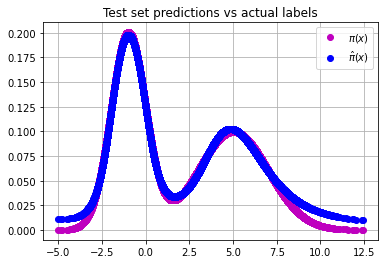

10 0.040630700018524445
10 8.774972715767209e-05
Finished Training
94.5330798625946


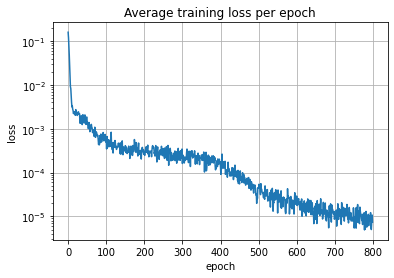

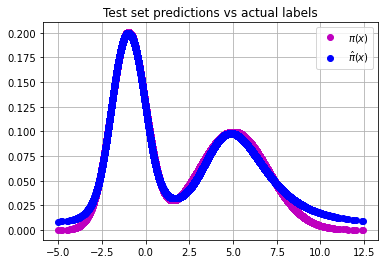

11 0.0367731338754154
11 4.9357859828489985e-05
Finished Training
94.18359065055847


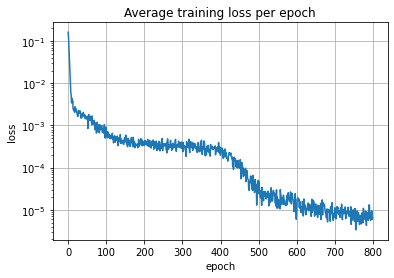

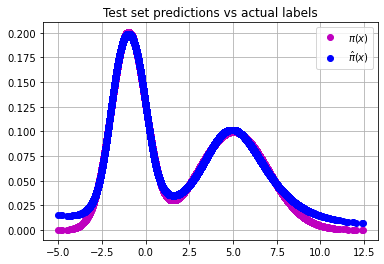

12 0.03411465883960011
12 5.482841009734496e-05
Finished Training
94.22703504562378


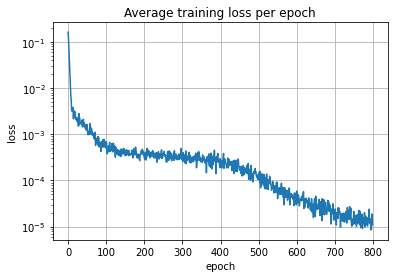

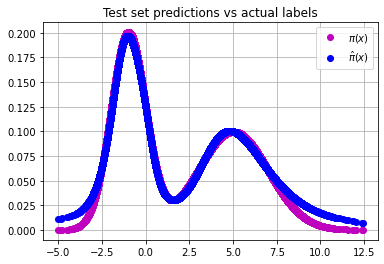

13 0.04194685244683201
13 0.00010330582718429955
Finished Training
94.13604784011841


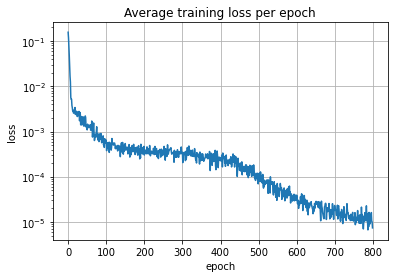

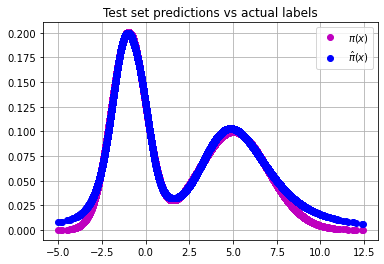

14 0.03208143714853307
14 7.371531079951291e-05
Finished Training
93.36161041259766


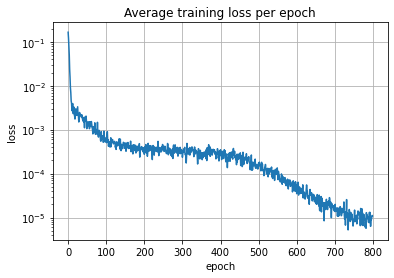

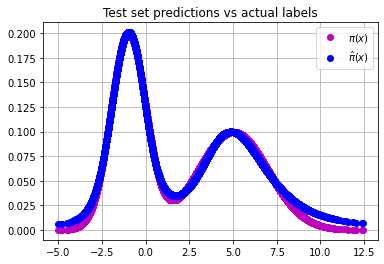

15 0.028801059048616885
15 4.861622837220759e-05
Finished Training
94.23112678527832


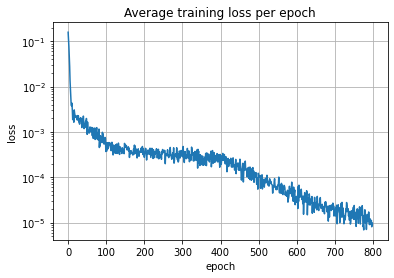

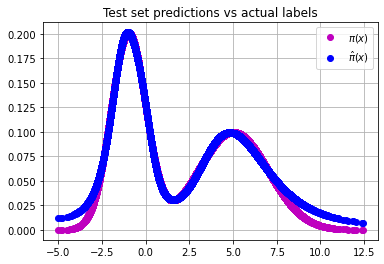

16 0.041708101469469065
16 8.37292070650154e-05
Finished Training
93.62125301361084


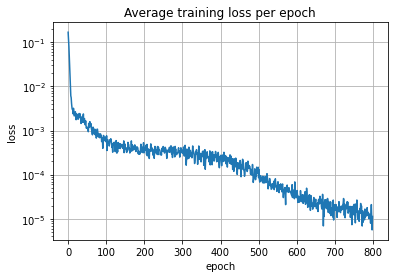

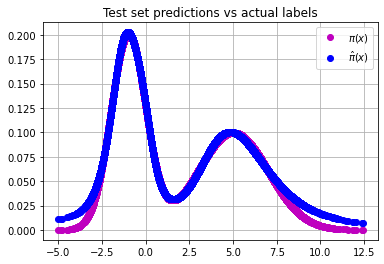

17 0.03974311291626546
17 7.863486785281109e-05
Finished Training
93.75192141532898


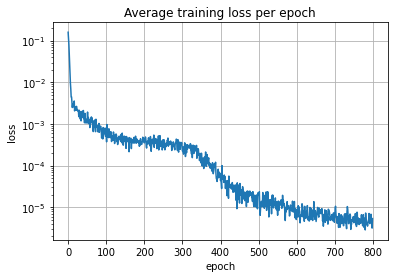

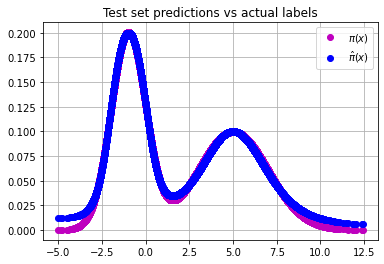

18 0.02667848730205819
18 3.0282219076647234e-05
Finished Training
93.91212558746338


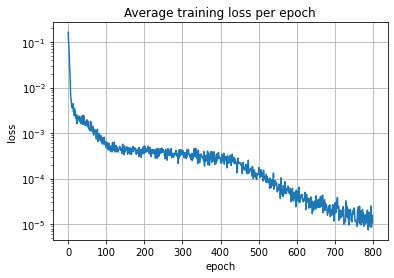

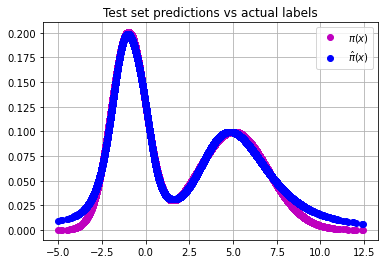

19 0.034910283857655384
19 6.779901004102435e-05
Finished Training
94.4879720211029


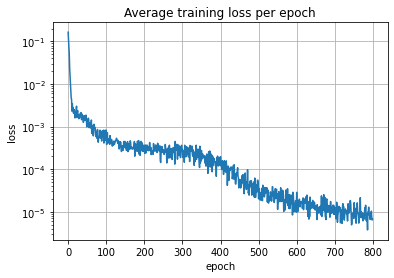

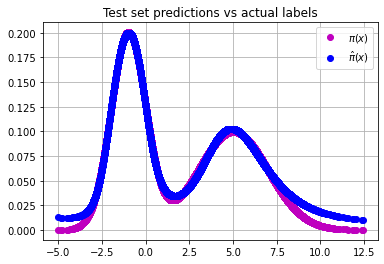

20 0.04163234047268797
20 8.197081310866639e-05
Finished Training
121.95377039909363


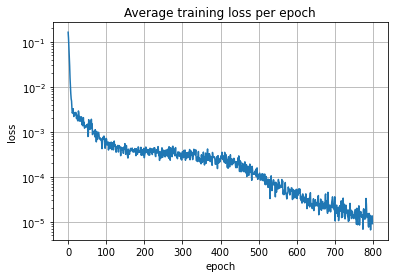

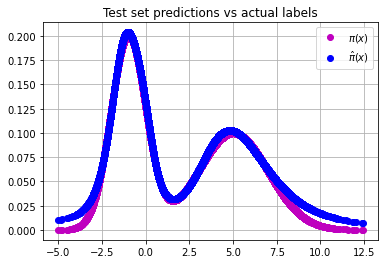

21 0.03802464243509163
21 8.299596760458311e-05
Finished Training
95.96554565429688


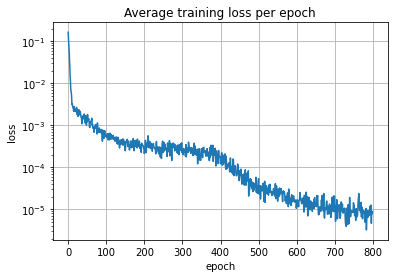

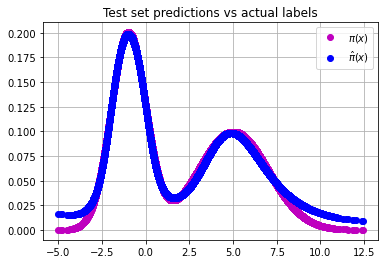

22 0.043339369407548525
22 6.646613688661327e-05
Finished Training
96.16820311546326


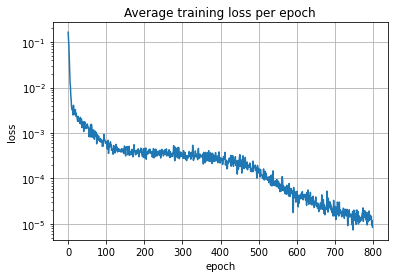

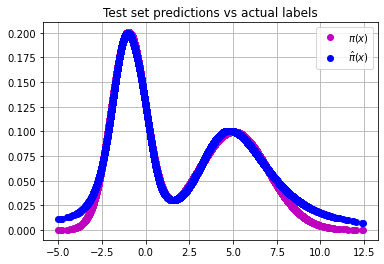

23 0.04122358592091834
23 9.397474515181576e-05
Finished Training
95.04426789283752


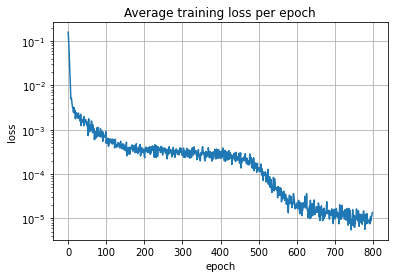

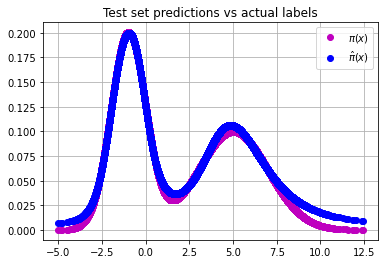

24 0.034833341333020636
24 9.095079980319899e-05
Finished Training
93.35421681404114


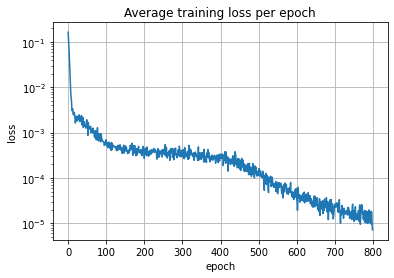

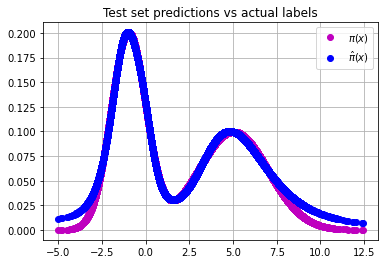

25 0.039673945988865866
25 8.141912473506334e-05
Finished Training
93.19339156150818


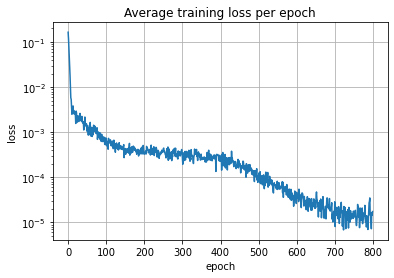

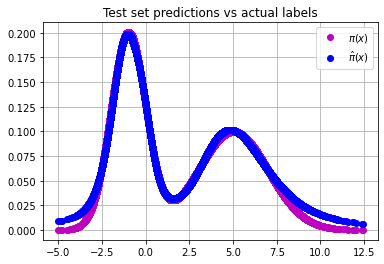

26 0.03408279390197142
26 7.747206798338098e-05
Finished Training
93.0693769454956


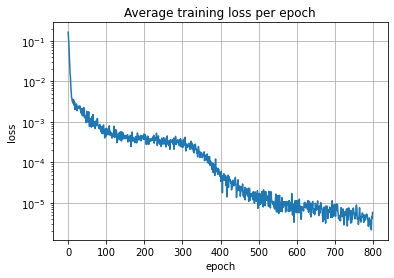

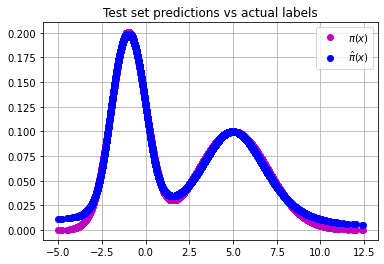

27 0.02427032615851391
27 2.490241213382538e-05
Finished Training
95.2430772781372


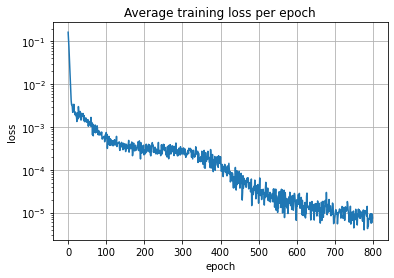

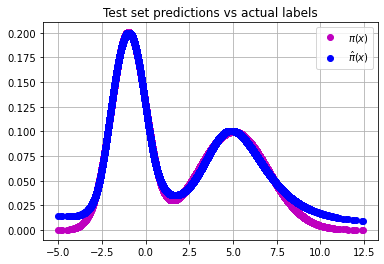

28 0.040046380888155826
28 6.588725426163073e-05
Finished Training
100.96100759506226


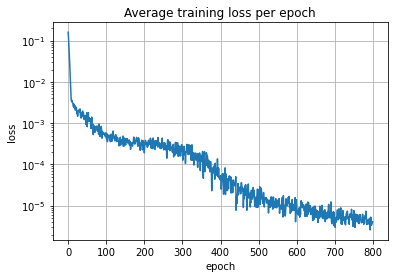

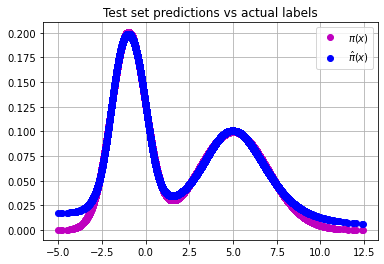

29 0.035480738880206183
29 5.435913776846907e-05
Finished Training
100.88993859291077


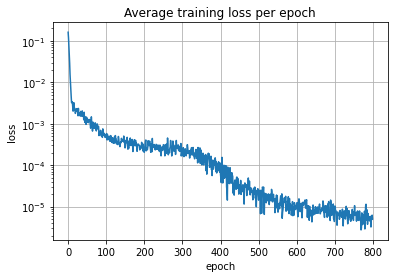

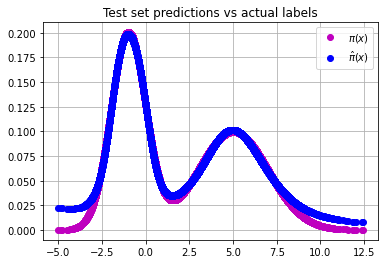

30 0.04552391754558298
30 8.552146221671556e-05
Finished Training
96.3445725440979


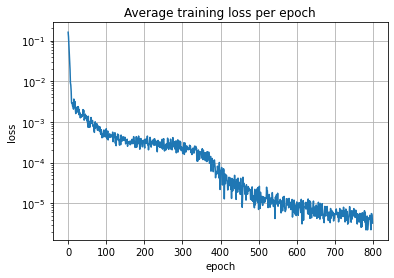

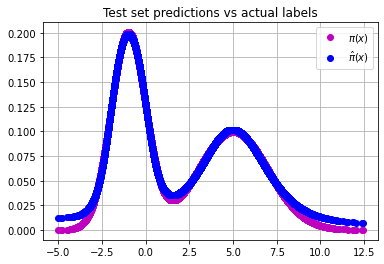

31 0.030440249470256437
31 4.967156877018206e-05
Finished Training
124.32545781135559


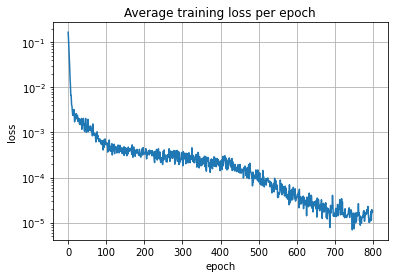

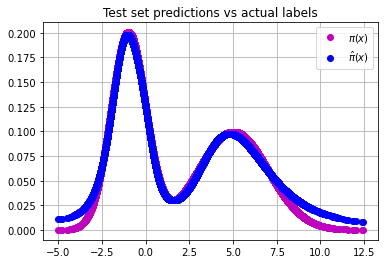

32 0.04294478475092817
32 8.819977163602293e-05
Finished Training
95.27380013465881


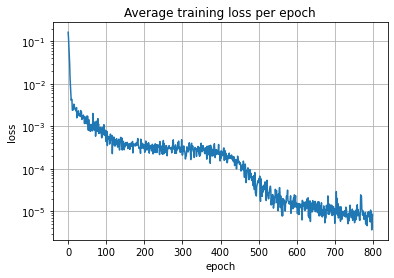

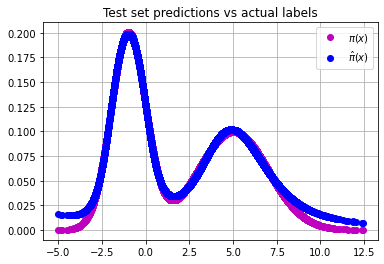

33 0.03776849335845443
33 6.750121945759229e-05
Finished Training
102.43195581436157


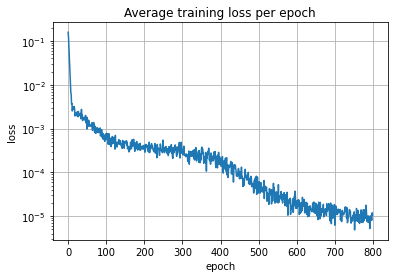

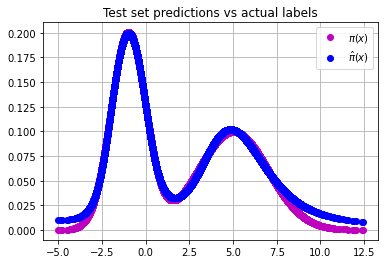

34 0.03438792793462918
34 5.9648634979546925e-05
Finished Training
107.31440258026123


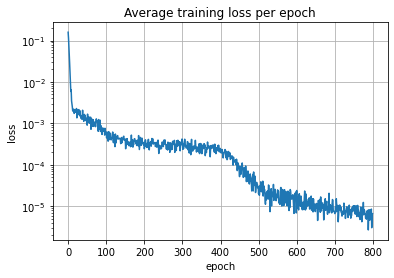

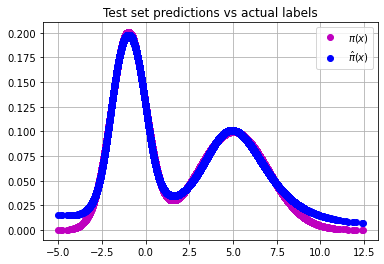

35 0.03507921253116343
35 5.7078339797586917e-05
Finished Training
104.42614650726318


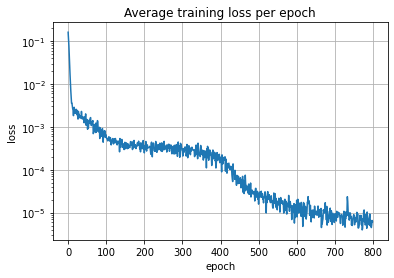

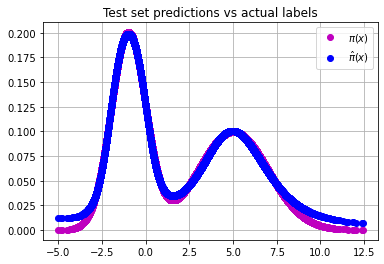

36 0.031143807166502478
36 4.437615516148585e-05
Finished Training
105.2695951461792


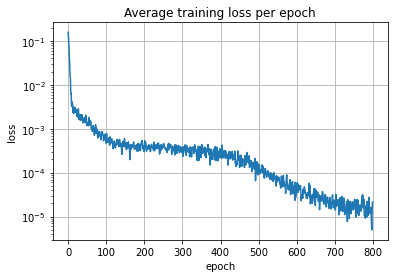

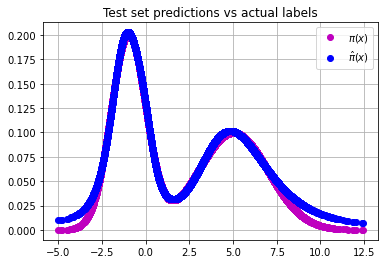

37 0.03676030160573628
37 7.432601315775553e-05
Finished Training
101.35623240470886


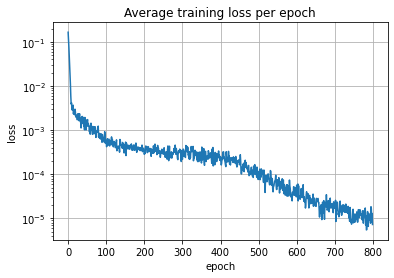

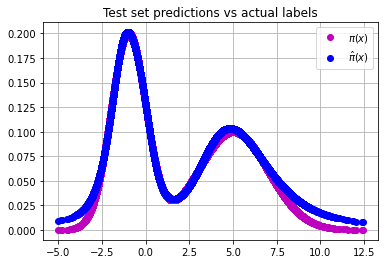

38 0.038906803116926875
38 9.894774442106308e-05
Finished Training
102.87004160881042


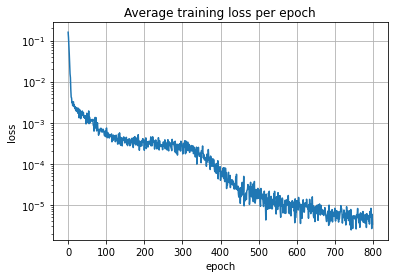

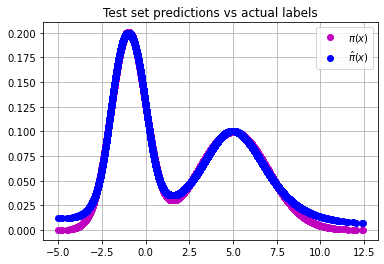

39 0.0300470321183461
39 4.132614547133367e-05
Finished Training
102.73932385444641


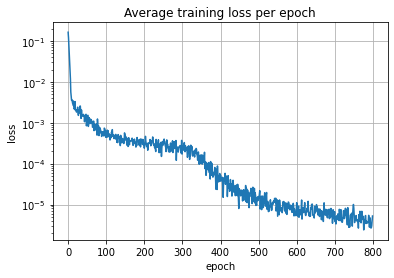

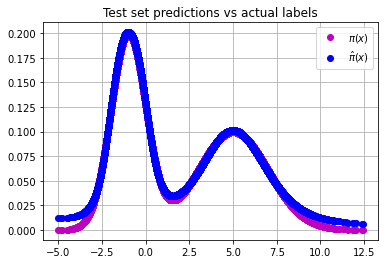

40 0.028259072997621603
40 3.669231373996483e-05
Finished Training
100.93967700004578


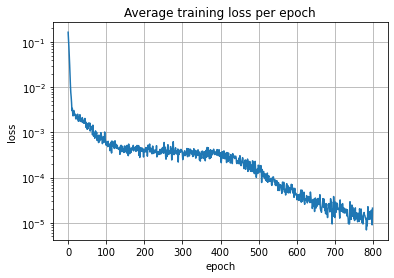

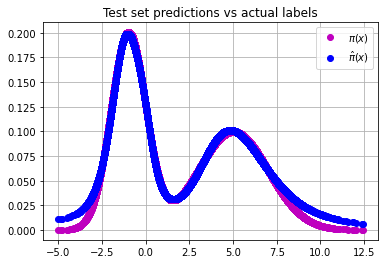

41 0.03729036299808945
41 8.227590516271299e-05
Finished Training
103.06248807907104


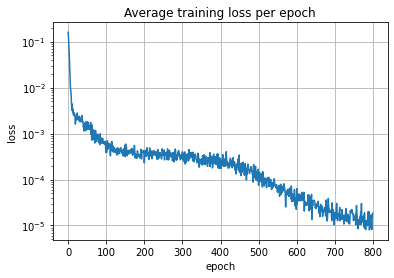

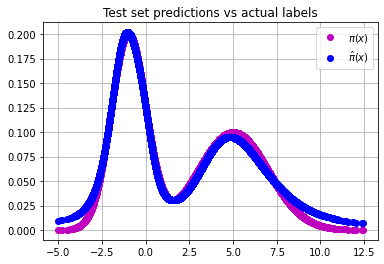

42 0.036548487434973756
42 5.206297760434515e-05
Finished Training
139.71410202980042


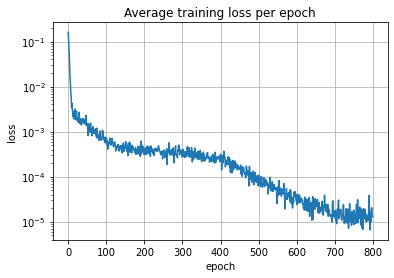

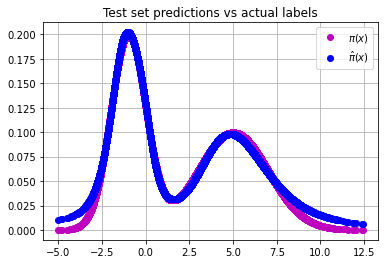

43 0.03610779436118012
43 5.564803004004441e-05
Finished Training
102.53404879570007


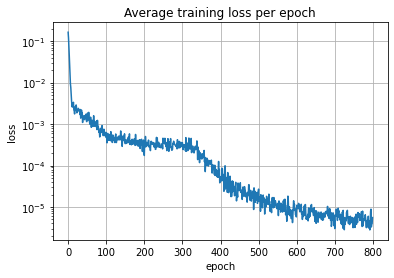

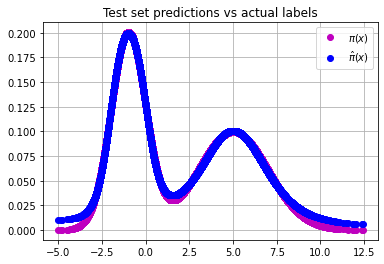

44 0.024927529043474853
44 3.1057841626704734e-05
Finished Training
105.13024640083313


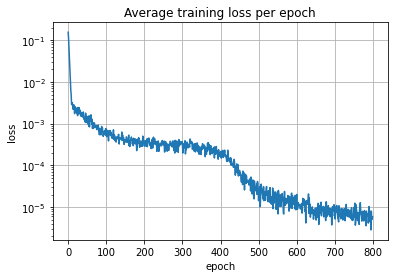

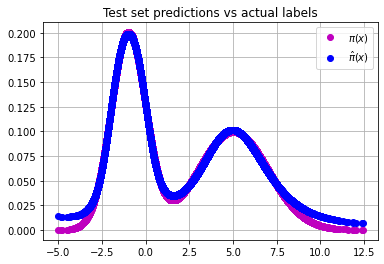

45 0.03224586096805108
45 4.925284087706039e-05
Finished Training
95.74408030509949


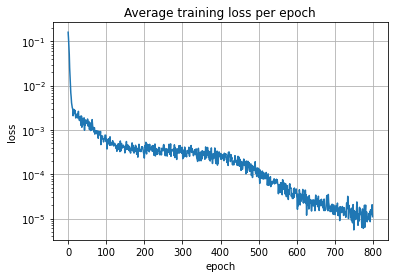

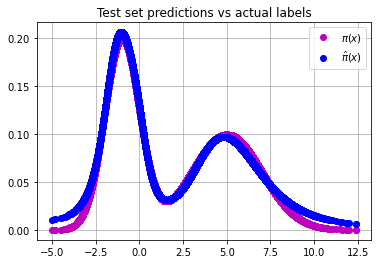

46 0.03636558080477944
46 4.959107283184637e-05
Finished Training
93.60434365272522


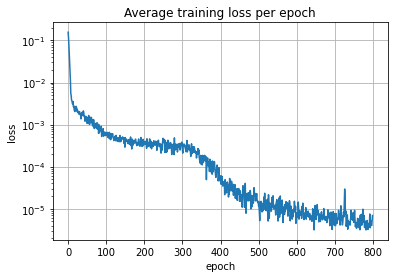

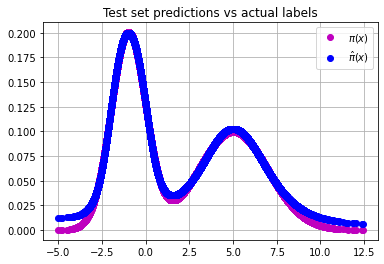

47 0.028291197920517378
47 4.43287049086368e-05
Finished Training
93.79614019393921


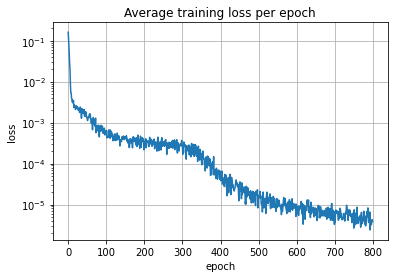

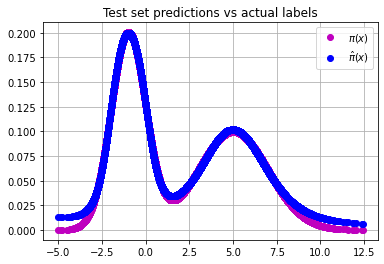

48 0.029453898194939074
48 4.256611011777788e-05
Finished Training
93.46479892730713


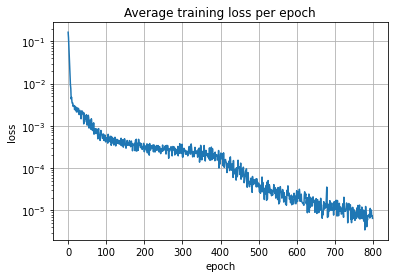

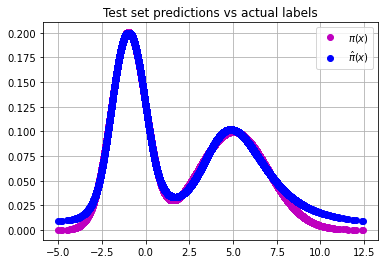

49 0.0367066472953719
49 6.335064619188064e-05
Finished Training
94.82741689682007


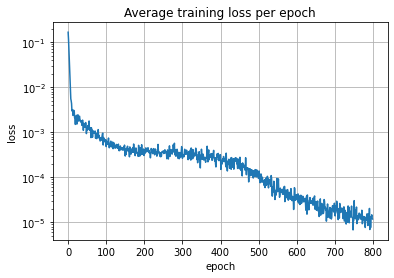

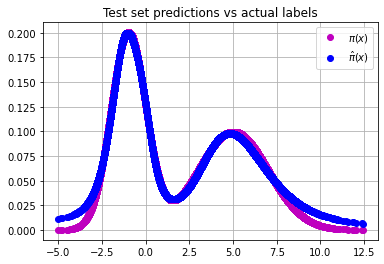

50 0.038252288986710806
50 6.625844212186597e-05
Finished Training
98.52995038032532


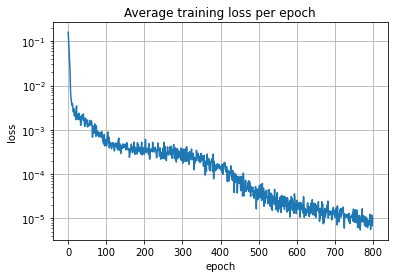

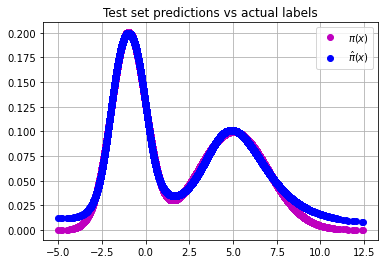

51 0.03525428178647331
51 5.451476114631773e-05
Finished Training
95.53662967681885


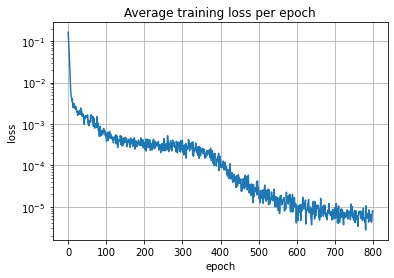

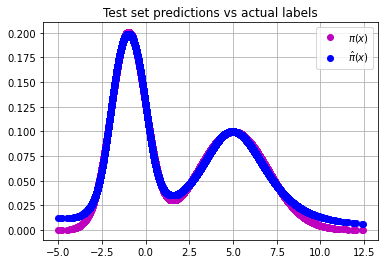

52 0.028973155018231757
52 3.7501172663786e-05
Finished Training
97.18547224998474


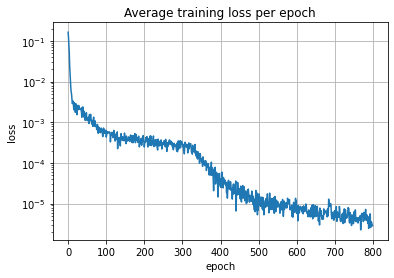

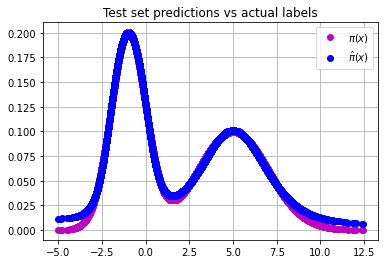

53 0.02747374152278138
53 3.5276829837755565e-05
Finished Training
140.17483520507812


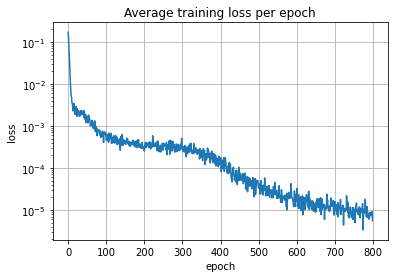

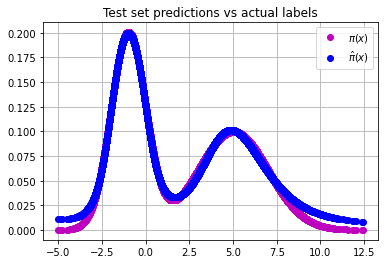

54 0.03519690731530323
54 5.536263745913992e-05
Finished Training
103.99330139160156


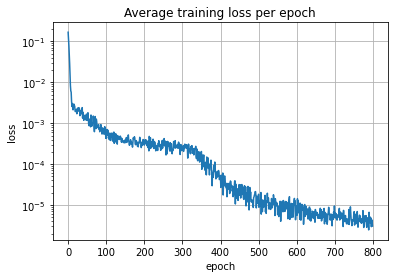

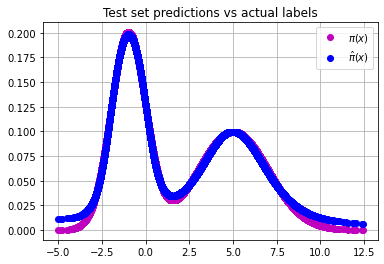

55 0.02751831223072638
55 3.5046151438132436e-05
Finished Training
94.56828880310059


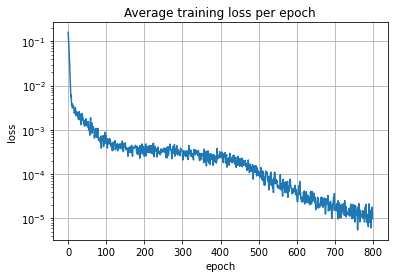

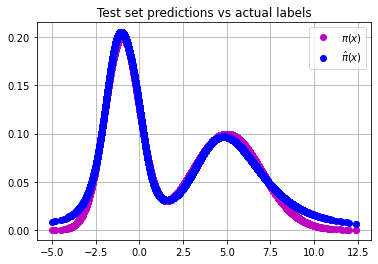

56 0.03430946834848024
56 4.5626086488063205e-05
Finished Training
94.02156162261963


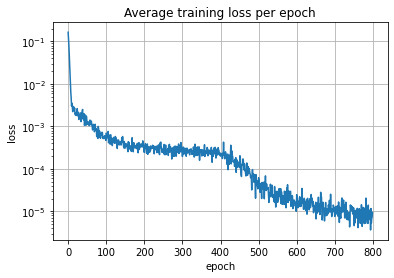

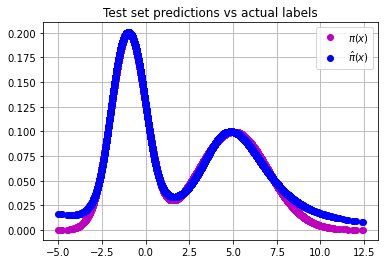

57 0.04090998018406984
57 6.441690333957215e-05
Finished Training
95.80797529220581


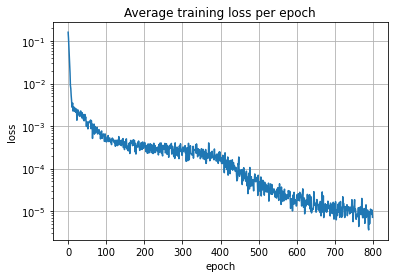

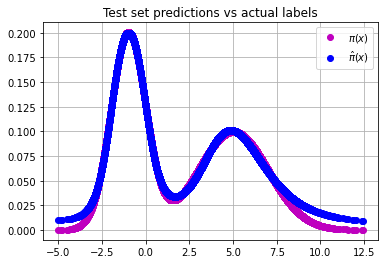

58 0.03779923987957955
58 6.606773309070604e-05
Finished Training
95.00618410110474


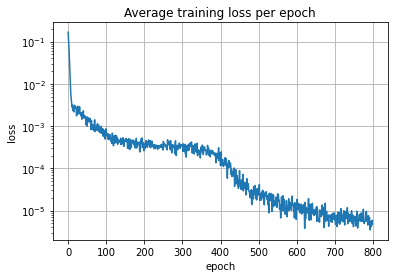

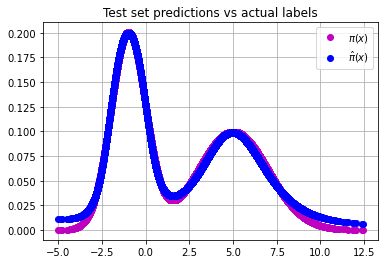

59 0.028203245777696815
59 3.093468472677286e-05
Finished Training
94.1835207939148


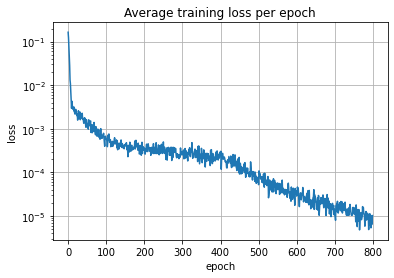

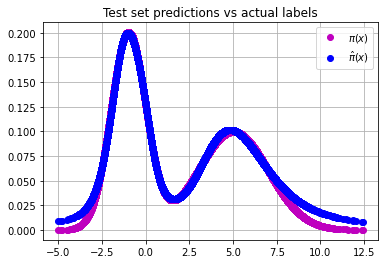

60 0.03884911983657646
60 8.498125547566091e-05
Finished Training
95.85278582572937


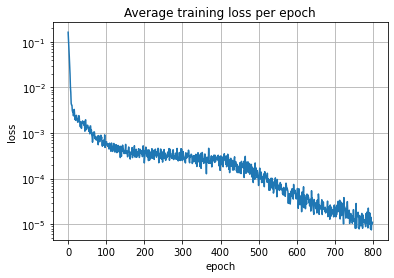

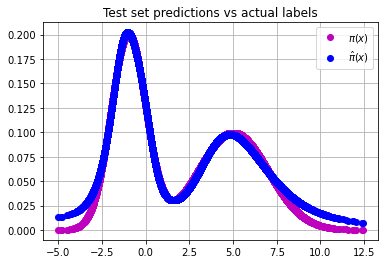

61 0.04462357711630862
61 8.350550998173567e-05
Finished Training
95.20664691925049


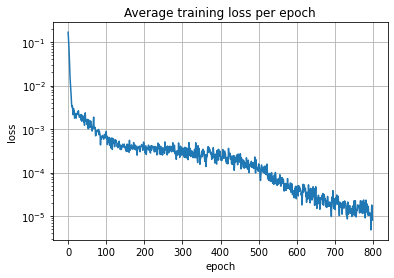

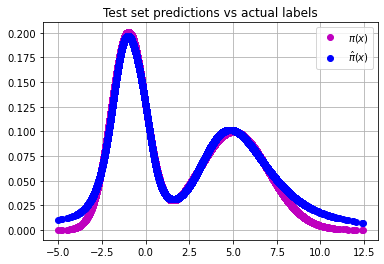

62 0.04050015474394348
62 0.00011055850287773321
Finished Training
94.92881393432617


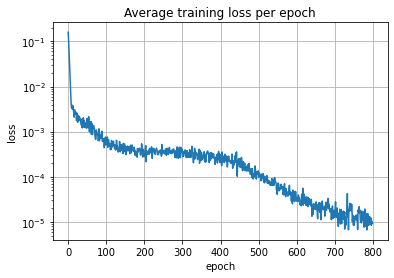

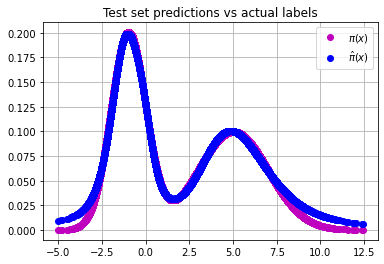

63 0.03388564115982984
63 6.592042101633329e-05
Finished Training
94.88063359260559


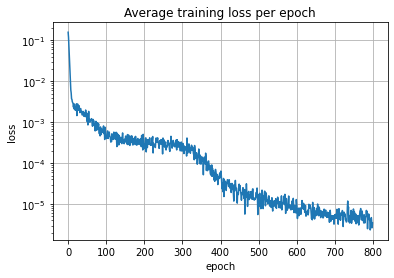

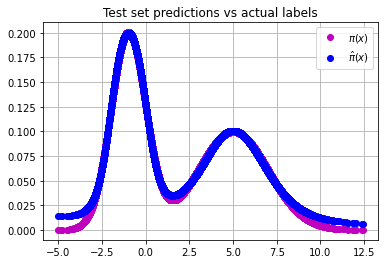

64 0.030452043415898775
64 4.154332085200823e-05
Finished Training
126.7994773387909


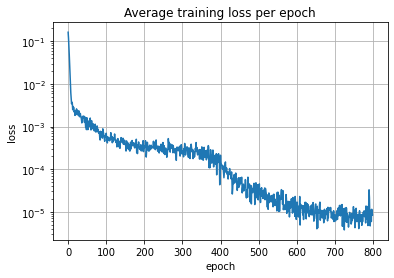

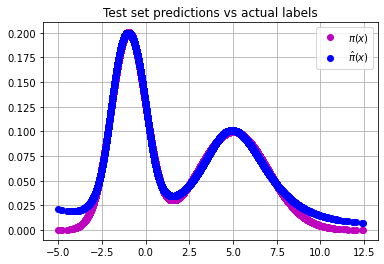

65 0.04114981199713678
65 6.475764075533203e-05
Finished Training
94.46494197845459


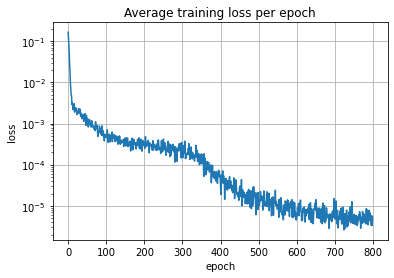

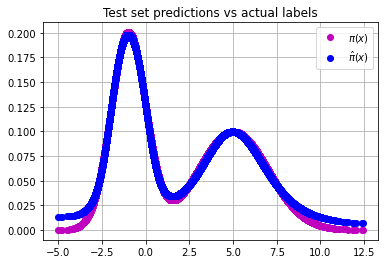

66 0.031677567113686945
66 4.345836503879155e-05
Finished Training
98.70071959495544


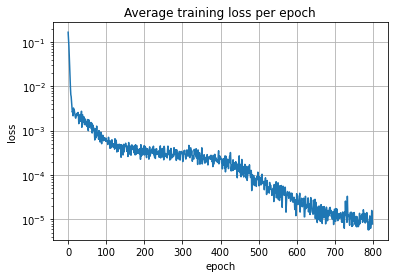

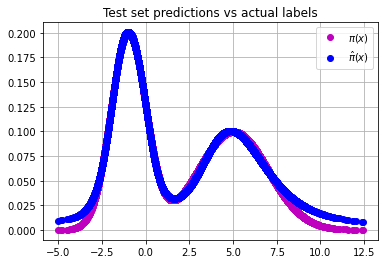

67 0.036599018872363165
67 6.170804422664809e-05
Finished Training
95.43590521812439


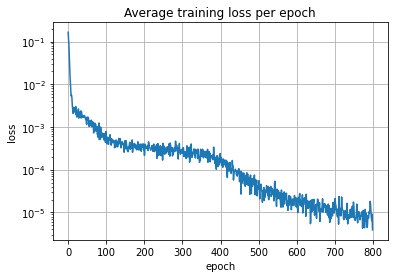

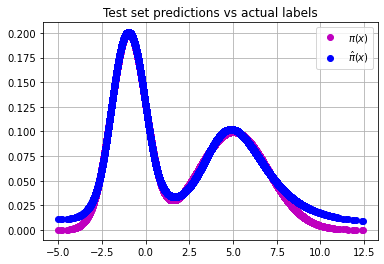

68 0.03770862888357334
68 6.588543947339895e-05
Finished Training
94.08004522323608


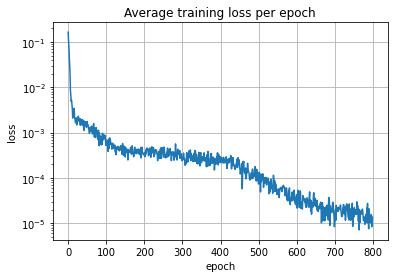

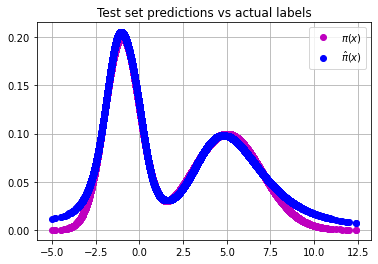

69 0.0413927005192682
69 7.026181336039158e-05
Finished Training
100.47810220718384


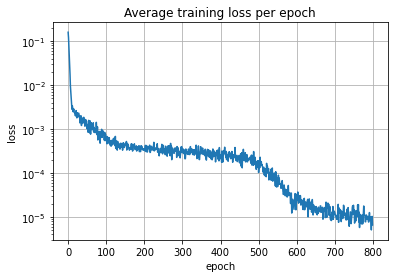

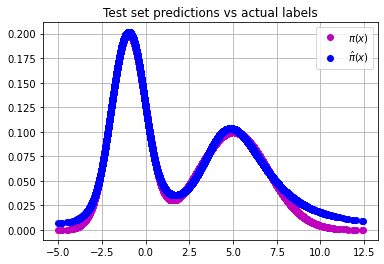

70 0.03523444117235713
70 7.003491638532973e-05
Finished Training
102.33007454872131


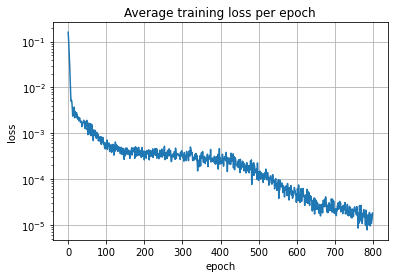

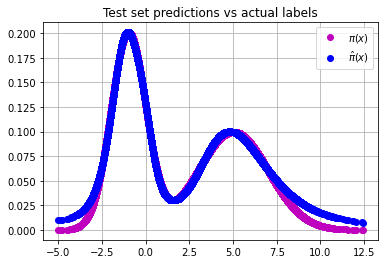

71 0.039605832586684514
71 8.249909980611824e-05
Finished Training
103.45677900314331


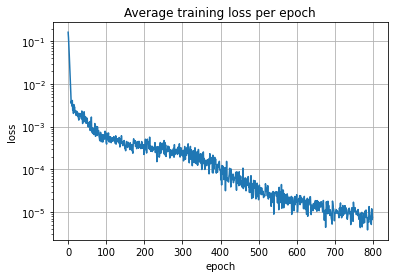

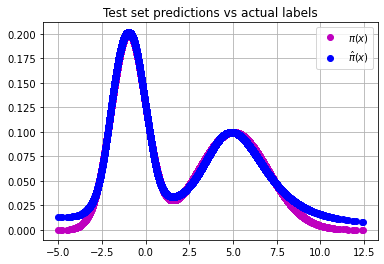

72 0.03721504818621261
72 5.018667970484453e-05
Finished Training
102.76884031295776


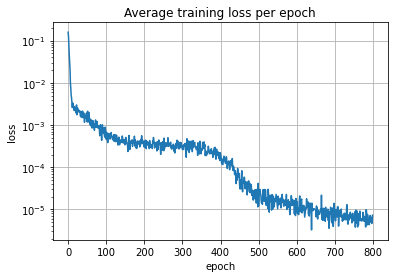

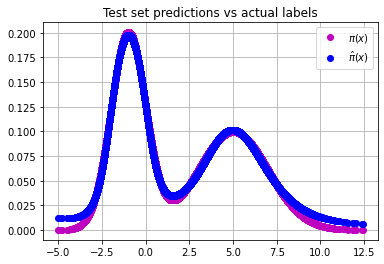

73 0.028303180316452858
73 4.274070460736191e-05
Finished Training
100.03128051757812


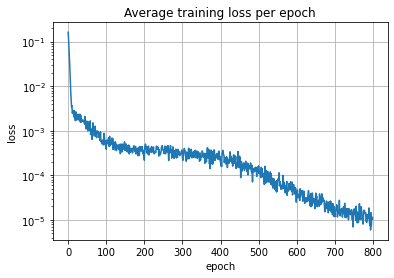

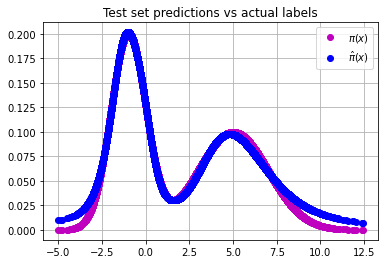

74 0.03965599214436423
74 6.825867205203431e-05
Finished Training
104.22391152381897


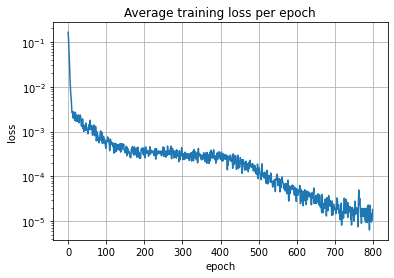

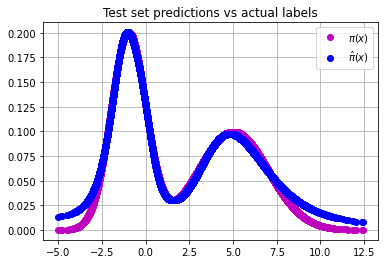

75 0.04599897682910166
75 9.067608805257424e-05
Finished Training
137.53245329856873


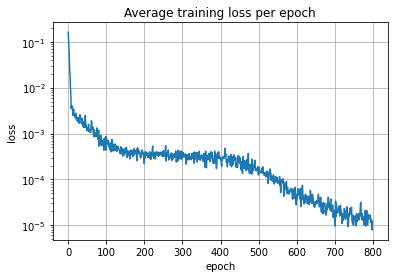

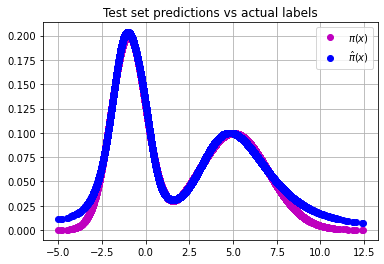

76 0.039111845352460504
76 7.286286006461173e-05


In [ ]:
niters = 350
kl_div = np.zeros(niters)
mse    = np.zeros(niters)

for i in range(niters):
    data       = generate_data()
    data_set   = data[0]; labels = data[1]
    dataloader = data[2]
    t = time.time()
    dat = training(dataloader)
    elapsed = time.time() - t
    print(elapsed)
    losss = dat[0]; nepochs = dat[1]; net = dat[2];
    plot_loss(nepochs, losss,i)
    prediction = plot_prediction(test_set,test_labels,net,i)
    Z     =   normalisation_const(net)
    prediction = prediction / Z
#    pred = np.copy(prediction)

#     for k in range(len(prediction)):
#         if prediction[k] == 0:
# #            print('zero prediction')
#             prediction[k] = 10**(-20) 

    kl_div[i] = kl_divergence(V,prediction)
    mse[i]    = mean_sq_error(V,prediction)
    print(i,kl_div[i])
    print(i,mse[i])

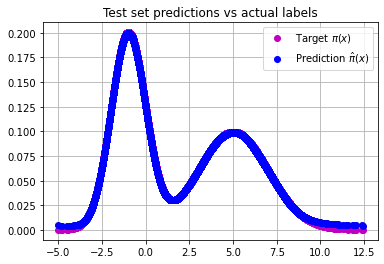

In [79]:
prediction = np.zeros(np.shape(test_labels)[0])
for j in range(np.shape(test_set)[0]):
    prediction[j] = net(test_set[j])#[0]
prediction = np.reshape(prediction,(len(prediction),1))
    
plt.plot(test_set,test_labels, 'om',label = 'Target $\pi(x)$')
plt.plot(test_set,prediction, 'o', color='blue', label = 'Prediction $\hat{\pi}(x)$')
plt.grid()
#    plt.ticklabel_format(axis="y", style="plain")
plt.title('Test set predictions vs actual labels')
plt.legend()
#plt.show()
plt.savefig('pred_vs_lab'.format(i))

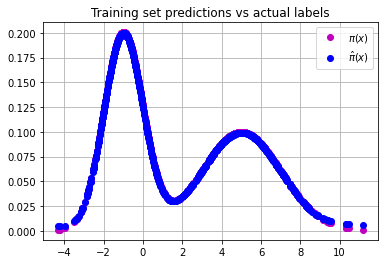

In [80]:
prediction = np.zeros(np.shape(labels)[0])
for j in range(np.shape(data_set)[0]):
    prediction[j] = net(torch.FloatTensor(data_set[j]))#[0]
prediction = np.reshape(prediction,(len(prediction),1))
    
plt.plot(data_set,labels, 'om',label = '$\pi(x)$')
plt.plot(data_set,prediction, 'o', color='blue', label = '$\hat{\pi}(x)$')
plt.grid()
#    plt.ticklabel_format(axis="y", style="plain")
plt.title('Training set predictions vs actual labels')
plt.legend()
plt.show()
#plt.savefig('pred_vs_lab{0}'.format(i))

In [81]:
print(np.sum(kl_div)/len(kl_div))

0.014402220557621487


In [82]:
# kl_div5 = kl_div
# mse_5 = mse

In [83]:
# kl_div30 = np.hstack((kl_div30,kl_div))
#mse_30 = np.hstack((mse_30,mse))

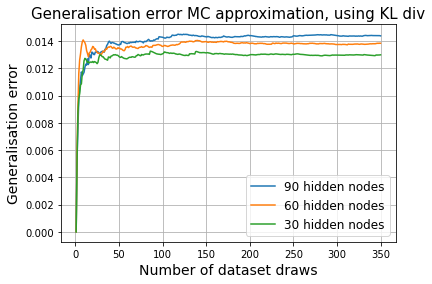

In [89]:
# ge120 = np.zeros(len(kl_div120))
# ge100 = np.zeros(len(kl_div100))
ge90 = np.zeros(len(kl_div90))
ge60 = np.zeros(len(kl_div60))
ge30 = np.zeros(len(kl_div30))
# ge20 = np.zeros(len(kl_div20))
# ge4 = np.zeros(len(kl_div4))
for i in range(len(kl_div30)):
#     ge120[i] = sum(kl_div120[:i])/(i+1)
#     ge100[i] = sum(kl_div100[:i])/(i+1)
    ge90[i] = sum(kl_div90[:i])/(i+1)
    ge60[i] = sum(kl_div60[:i])/(i+1)
    ge30[i] = sum(kl_div30[:i])/(i+1)
#     ge20[i] = sum(kl_div20[:i])/(i+1)
#     ge4[i] = sum(kl_div4[:i])/(i+1)
    
i = np.linspace(1,len(kl_div30),len(kl_div30))
# plt.plot(i,ge120,label = '120 hidden nodes')#,color='b')
# plt.plot(i,ge100,label = '100 hidden nodes')#,color='orange')
plt.plot(i,ge90,label = '90 hidden nodes')#,color='g')
plt.plot(i,ge60,label = '60 hidden nodes')#,color='g')
plt.plot(i,ge30,label = '30 hidden nodes')#,color='g')
# plt.plot(i,ge20,label = '20 hidden nodes')#,color='g')
# plt.plot(i,ge4,label = '4 hidden nodes')#,color='g')
plt.grid()
plt.xlabel('Number of dataset draws',fontsize = 14)
plt.ylabel('Generalisation error',fontsize = 14)
plt.title('Generalisation error MC approximation, using KL div',fontsize = 15)
plt.legend(fontsize = 12)
plt.savefig('Generalization_error_Monte_Carlo_approximation_30_60_90_continuousKLdiv')


In [85]:
#kl_div5 = np.hstack((kl_div_5,kl_div))

In [86]:
# # cont_ge120 = np.zeros(len(cont_kl_div120))
# # cont_ge100 = np.zeros(len(cont_kl_div100))
# cont_ge30 = np.zeros(len(cont_kl_div30))
# # cont_ge20 = np.zeros(len(cont_kl_div20))
# # cont_ge4 = np.zeros(len(cont_kl_div4))
# for i in range(len(cont_kl_div30)):
# #     cont_ge120[i] = sum(cont_kl_div120[:i])/(i+1)
# #     cont_ge100[i] = sum(cont_kl_div100[:i])/(i+1)
#      cont_ge30[i] = sum(cont_kl_div30[:i])/(i+1)
# #     cont_ge20[i] = sum(cont_kl_div20[:i])/(i+1)
# #     cont_ge4[i] = sum(cont_kl_div4[:i])/(i+1)
    
# i = np.linspace(1,len(cont_kl_div30),len(cont_kl_div30))
# # plt.plot(i,cont_ge120,label = '120 hidden nodes')#,color='b')
# # plt.plot(i,cont_ge100,label = '100 hidden nodes')#,color='orange')
# plt.plot(i,cont_ge30,label = '30 hidden nodes')#,color='g')
# # plt.plot(i,cont_ge20,label = '20 hidden nodes')#,color='g')
# # plt.plot(i,cont_ge4,label = '4 hidden nodes')#,color='g')
# plt.grid()
# plt.xlabel('Number of dataset draws',fontsize = 14)
# plt.ylabel('Generalisation error',fontsize = 14)
# plt.title('Generalisation error Monte Carlo approximation',fontsize = 15)
# plt.legend(fontsize = 12)
# plt.savefig('cont_Generalization_error_Monte_Carlo_approximation_30_60_90_continuousKL1')


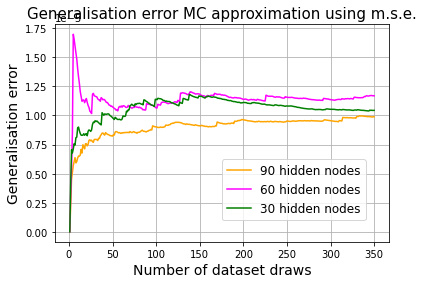

In [88]:
# mse_ge120 = np.zeros(len(mse_120))
# mse_ge100 = np.zeros(len(mse_100))
mse_ge90 = np.zeros(len(mse_90))
mse_ge60 = np.zeros(len(mse_60))
mse_ge30 = np.zeros(len(mse_30))
# mse_ge20 = np.zeros(len(mse_20))
# mse_ge4 = np.zeros(len(mse_4))
for i in range(len(mse_30)):
#     mse_ge120[i] = sum(mse_120[:i])/(i+1)
#     mse_ge100[i] = sum(mse_100[:i])/(i+1)
    mse_ge90[i] = sum(mse_90[:i])/(i+1)
    mse_ge60[i] = sum(mse_60[:i])/(i+1)
    mse_ge30[i] = sum(mse_30[:i])/(i+1)

#     mse_ge20[i] = sum(mse_20[:i])/(i+1)
#     mse_ge4[i] = sum(mse_4[:i])/(i+1)
    
i = np.linspace(1,len(mse_30),len(mse_30))
# plt.plot(i,mse_ge120,label = '120 hidden nodes')#,color='b')
# plt.plot(i,mse_ge100,label = '100 hidden nodes',color='blue')
plt.plot(i,mse_ge90,label = '90 hidden nodes',color='orange')
plt.plot(i,mse_ge60,label = '60 hidden nodes',color='magenta')
plt.plot(i,mse_ge30,label = '30 hidden nodes',color='green')
# plt.plot(i,mse_ge20,label = '20 hidden nodes',color='green')
# plt.plot(i,mse_ge4,label = '4 hidden nodes',color='orange')
plt.grid()
plt.xlabel('Number of dataset draws',fontsize = 14)
plt.ylabel('Generalisation error',fontsize = 14)
plt.title('Generalisation error MC approximation using m.s.e.',fontsize = 15)
plt.legend(fontsize = 12,loc=(0.5,0.1))
plt.savefig('mse_generalization_error_Monte_Carlo_approximation_30_60_90')
